In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

In [13]:
symbols = 'BTC'.split(',')
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, horizon=24, price_type=None, interval_sec=24 * 60 * 60)
df.to_pickle('/tmp/df_btc_price_type_none_daily.pkl')
display(df)

,,op,hi,lo,cl,volume,execution_start_at,ret
timestamp,symbol,,,,,,,
2019-07-20 00:00:00+00:00,BTC,10564.25,11108.75,10385.25,10765.75,1.172032e+08,2019-07-21 00:00:00+00:00,-0.015635
2019-07-21 00:00:00+00:00,BTC,10765.75,10834.00,10322.00,10588.75,7.400292e+07,2019-07-22 00:00:00+00:00,-0.032630
2019-07-22 00:00:00+00:00,BTC,10588.75,10688.25,10059.00,10321.50,6.869815e+07,2019-07-23 00:00:00+00:00,-0.055818
2019-07-23 00:00:00+00:00,BTC,10321.50,10323.25,9776.50,9841.75,9.836957e+07,2019-07-24 00:00:00+00:00,0.020936
2019-07-24 00:00:00+00:00,BTC,9835.25,9915.75,9517.75,9770.00,7.770911e+07,2019-07-25 00:00:00+00:00,-0.015492
...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00+00:00,BTC,19808.00,20492.00,19798.00,20047.00,2.746670e+09,2022-09-01 00:00:00+00:00,0.001165
2022-09-01 00:00:00+00:00,BTC,20047.00,20204.00,19549.00,20133.00,2.719472e+09,2022-09-02 00:00:00+00:00,-0.004417
2022-09-02 00:00:00+00:00,BTC,20133.00,20444.00,19743.00,19945.00,2.532769e+09,2022-09-03 00:00:00+00:00,-0.008006


In [3]:
!pip install quandl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 10.2 MB/s eta 0:00:00


In [37]:
import quandl

bchain_cols = [
    'DIFF',
    'MWNUS',
    'AVBLS',
    'BLCHS',
    'ATRCT',
    'MIREV',
    'HRATE',
    'CPTRA',
    'ETRVU',
    'ETRAV',
    'TOUTV',
    'NADDU',
    'NTREP',
    'NTRAT',
    'NTRAN',
    'TRFUS',
]


def get(name):
    return quandl.get("BCHAIN/{}".format(name))['Value'].rename('bchain_{}'.format(name.lower()))

df = pd.concat(map(get, bchain_cols), axis=1)

df = df.reset_index()
df = df.rename(columns={ 'Date': 'timestamp' })
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d', utc=True)
df = df.set_index('timestamp')
df.to_pickle('/tmp/df_bchain.pkl')
display(df)

,bchain_diff,bchain_mwnus,bchain_avbls,bchain_blchs,bchain_atrct,bchain_mirev,bchain_hrate,bchain_cptra,bchain_etrvu,bchain_etrav,bchain_toutv,bchain_naddu,bchain_ntrep,bchain_ntrat,bchain_ntran,bchain_trfus
timestamp,,,,,,,,,,,,,,,,
2009-01-02 00:00:00+00:00,1.000000e+00,2.0,0.000272,0.000000,NaN,0.000000e+00,NaN,0.000000,0.000000e+00,0.000000,5.000000e+01,1.0,1.0,1.0,1.0,0.000000
2009-01-03 00:00:00+00:00,0.000000e+00,2.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,1.0,0.0,0.000000
2009-01-04 00:00:00+00:00,0.000000e+00,2.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,1.0,0.0,0.000000
2009-01-05 00:00:00+00:00,0.000000e+00,2.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,1.0,0.0,0.000000
2009-01-06 00:00:00+00:00,0.000000e+00,2.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,1.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00+00:00,3.029372e+13,84268216.0,1.212706,424550.379084,7.933333,1.897380e+07,2.198627e+08,72.091377,3.158898e+09,156167.774259,4.242119e+06,652024.0,260053.0,760731943.0,260425.0,266117.535093
2022-09-01 00:00:00+00:00,3.097705e+13,84312116.0,1.268660,424727.604251,8.241667,1.751932e+07,2.125031e+08,65.365240,2.826592e+09,141593.269793,4.197325e+06,685449.0,267627.0,760992653.0,268022.0,293638.018495
2022-09-02 00:00:00+00:00,3.097705e+13,84355552.0,1.407586,424902.306350,10.683333,1.657300e+07,1.986442e+08,61.248115,2.841993e+09,141355.398941,3.912132e+06,710783.0,270173.0,761259557.0,270588.0,367305.401444


In [90]:
df = pd.read_pickle('/tmp/df_btc_price_type_none_daily.pkl')
df = df.reset_index().set_index('timestamp')
df_bchain = pd.read_pickle('/tmp/df_bchain.pkl')
df = df.join(df_bchain)
df = df.fillna(0)
display(df)

for col in df.columns:
    if col.startswith('bchain_') or col in ['cl']:
        df[col] = np.log(1 + df[col]) # .diff(1).diff(1).fillna(0)

display(df.describe())
display(df.corr())

,symbol,op,hi,lo,cl,volume,execution_start_at,ret,bchain_diff,bchain_mwnus,...,bchain_hrate,bchain_cptra,bchain_etrvu,bchain_etrav,bchain_toutv,bchain_naddu,bchain_ntrep,bchain_ntrat,bchain_ntran,bchain_trfus
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-07-20 00:00:00+00:00,BTC,10564.25,11108.75,10385.25,10765.75,1.172032e+08,2019-07-21 00:00:00+00:00,-0.015635,9.064160e+12,40633456.0,...,7.975298e+07,74.506929,8.353196e+08,78195.594074,8.922829e+05,488968.0,306431.0,436711204.0,323002.0,540233.807604
2019-07-21 00:00:00+00:00,BTC,10765.75,10834.00,10322.00,10588.75,7.400292e+07,2019-07-22 00:00:00+00:00,-0.032630,9.064160e+12,40657260.0,...,6.713669e+07,70.805179,6.820364e+08,64623.494815,1.068961e+06,400500.0,270566.0,437033906.0,283934.0,396537.032389
2019-07-22 00:00:00+00:00,BTC,10588.75,10688.25,10059.00,10321.50,6.869815e+07,2019-07-23 00:00:00+00:00,-0.055818,9.064160e+12,40667475.0,...,7.119193e+07,66.345922,1.027286e+09,98420.772936,6.033169e+06,533399.0,304660.0,437318209.0,319399.0,573311.407712
2019-07-23 00:00:00+00:00,BTC,10321.50,10323.25,9776.50,9841.75,9.836957e+07,2019-07-24 00:00:00+00:00,0.020936,9.033161e+12,40728553.0,...,6.421285e+07,57.871615,9.463312e+08,94114.761397,1.208702e+06,531460.0,306607.0,437638264.0,320352.0,521481.250824
2019-07-24 00:00:00+00:00,BTC,9835.25,9915.75,9517.75,9770.00,7.770911e+07,2019-07-25 00:00:00+00:00,-0.015492,9.013787e+12,40737498.0,...,6.228281e+07,58.682011,1.334347e+09,137938.110658,1.513193e+06,490408.0,281997.0,437958818.0,295589.0,484498.810268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00+00:00,BTC,19808.00,20492.00,19798.00,20047.00,2.746670e+09,2022-09-01 00:00:00+00:00,0.001165,3.029372e+13,84268216.0,...,2.198627e+08,72.091377,3.158898e+09,156167.774259,4.242119e+06,652024.0,260053.0,760731943.0,260425.0,266117.535093
2022-09-01 00:00:00+00:00,BTC,20047.00,20204.00,19549.00,20133.00,2.719472e+09,2022-09-02 00:00:00+00:00,-0.004417,3.097705e+13,84312116.0,...,2.125031e+08,65.365240,2.826592e+09,141593.269793,4.197325e+06,685449.0,267627.0,760992653.0,268022.0,293638.018495
2022-09-02 00:00:00+00:00,BTC,20133.00,20444.00,19743.00,19945.00,2.532769e+09,2022-09-03 00:00:00+00:00,-0.008006,3.097705e+13,84355552.0,...,1.986442e+08,61.248115,2.841993e+09,141355.398941,3.912132e+06,710783.0,270173.0,761259557.0,270588.0,367305.401444


,op,hi,lo,cl,volume,ret,bchain_diff,bchain_mwnus,bchain_avbls,bchain_blchs,...,bchain_hrate,bchain_cptra,bchain_etrvu,bchain_etrav,bchain_toutv,bchain_naddu,bchain_ntrep,bchain_ntrat,bchain_ntran,bchain_trfus
count,1143.000000,1143.000000,1143.000000,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,...,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,27092.310367,27858.846457,26219.219816,9.945468,2.016002e+09,0.001330,30.564630,17.832866,0.774016,12.680820,...,18.722519,4.449755,21.533698,11.617735,14.464311,13.343197,12.532716,20.212450,12.546663,13.420046
std,18003.959599,18517.321692,17400.989119,0.755757,1.967796e+09,0.039277,0.298672,1.422815,0.077966,0.178702,...,0.306026,0.645491,1.369671,0.785510,0.676939,0.159132,0.154017,0.159166,0.158628,1.067998
min,4761.750000,5354.750000,3759.250000,8.479543,1.423007e+07,-0.400662,29.829776,0.000000,0.496913,12.350301,...,17.883870,3.239014,0.000000,0.000000,12.952621,12.845468,11.720053,19.894783,11.733193,11.181926
25%,9700.000000,9903.750000,9465.000000,9.179971,2.537996e+08,-0.017376,30.352892,17.685897,0.725863,12.523746,...,18.503332,3.904735,20.982631,11.351631,13.919954,13.230764,12.451563,20.079903,12.460420,12.668938
50%,22550.000000,23207.000000,21306.000000,10.023535,1.689161e+09,0.000383,30.575336,18.012013,0.793309,12.697684,...,18.715615,4.406583,21.580736,11.717210,14.463045,13.355351,12.546629,20.236624,12.561591,13.215478
75%,42390.500000,43409.500000,41283.500000,10.654703,3.303730e+09,0.018533,30.791504,18.189180,0.832112,12.838342,...,18.959238,5.058166,22.254549,11.973453,14.991971,13.454127,12.647244,20.350608,12.668650,13.999712
max,67657.000000,69190.000000,66300.000000,11.122221,1.313127e+10,0.205560,31.073076,18.251188,0.928392,12.960457,...,19.400531,5.708141,23.426811,13.240205,17.015353,13.766741,12.892842,20.451159,12.903573,16.643006


,op,hi,lo,cl,volume,ret,bchain_diff,bchain_mwnus,bchain_avbls,bchain_blchs,...,bchain_hrate,bchain_cptra,bchain_etrvu,bchain_etrav,bchain_toutv,bchain_naddu,bchain_ntrep,bchain_ntrat,bchain_ntran,bchain_trfus
op,1.000000,0.998988,0.997967,0.969864,0.759901,-0.036214,0.566309,0.099621,0.236130,0.702835,...,0.558615,0.938275,0.398236,-0.197700,0.567033,0.490987,-0.348684,0.705722,-0.376542,0.523685
hi,0.998988,1.000000,0.997834,0.971544,0.764348,-0.037196,0.565623,0.100873,0.241514,0.701398,...,0.556762,0.938179,0.400571,-0.193568,0.566934,0.496597,-0.344800,0.704543,-0.372717,0.531403
lo,0.997967,0.997834,1.000000,0.969671,0.736861,-0.040535,0.564735,0.104863,0.226885,0.704310,...,0.559407,0.938043,0.388278,-0.211679,0.565091,0.484592,-0.351049,0.706984,-0.379132,0.513150
cl,0.969864,0.971544,0.969671,1.000000,0.774367,-0.034701,0.651426,0.100937,0.268326,0.798707,...,0.633190,0.935479,0.416593,-0.194208,0.638843,0.518085,-0.399174,0.800384,-0.431512,0.538026
volume,0.759901,0.764348,0.736861,0.774367,1.000000,-0.022678,0.610707,0.060087,0.295915,0.714068,...,0.563321,0.714512,0.443934,0.041777,0.661159,0.454287,-0.304285,0.710949,-0.335501,0.345716
ret,-0.036214,-0.037196,-0.040535,-0.034701,-0.022678,1.000000,-0.035120,0.035767,0.012787,-0.024809,...,-0.025320,-0.041553,-0.008770,0.011148,-0.024069,0.006698,0.019315,-0.020871,0.014950,0.012516
bchain_diff,0.566309,0.565623,0.564735,0.651426,0.610707,-0.035120,1.000000,0.137377,0.367943,0.899060,...,0.923934,0.509285,0.310255,-0.058263,0.659315,0.513944,-0.361249,0.903158,-0.417100,0.263135
bchain_mwnus,0.099621,0.100873,0.104863,0.100937,0.060087,0.035767,0.137377,1.000000,0.000931,0.136203,...,0.198296,0.089666,0.038584,-0.019564,0.158176,0.146677,0.057836,0.135077,0.045811,0.014236
bchain_avbls,0.236130,0.241514,0.226885,0.268326,0.295915,0.012787,0.367943,0.000931,1.000000,0.247825,...,0.208010,0.030445,0.347651,0.326876,0.284914,0.669902,0.236435,0.267658,0.209473,0.632798
bchain_blchs,0.702835,0.701398,0.704310,0.798707,0.714068,-0.024809,0.899060,0.136203,0.247825,1.000000,...,0.856643,0.678753,0.335364,-0.150722,0.749767,0.443888,-0.518642,0.998680,-0.570095,0.225626


In [93]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
from sklearn.ensemble import BaggingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

class ExampleModelBtc:
    def __init__(self):
        self.max_data_sec = (7 + 4) * 24 * 60 * 60 # for predict script
        self.horizon = 96

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret']) - 0.5
        # df['ret_rank'] = norm.ppf(0.5 + 0.95 * df['ret_rank'])
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        ridge = Ridge(fit_intercept=False, alpha=0)
        self._model = ridge
        
        self._model = Pipeline([
            ('ss', StandardScaler(with_mean=False)),
            ('model', self._model)
        ])
        
        # lgbm = lgb.LGBMRegressor(
        #     # boosting="rf",
        #     # bagging_freq=3,
        #     # bagging_fraction=0.5,
        #     # colsample_bytree=0.3,
        #     # reg_lambda=1e7,
        #     n_estimators=1000,
        #     learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        # self._model = lgbm
        
        # models = []
        # for i in range(10):
        #     models.append(('nn{}'.format(i), KerasRegressor(
        #         model=partial(build_keras_model, len(features)), 
        #         random_state=i
        #     )))
        # self._model = VotingRegressor(models)
            
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features)), 
        #     # batch_size=16,
        #     random_state=1
        # )
        # self._model = BaggingRegressor(self._model, n_estimators=10, random_state=1, n_jobs=-1)
        # self._model = VotingRegressor([
        #     ('nn', self._model),
        #     ('ridge', ridge), 
        #     # ('lgbm', BaggingRegressor(lgbm, random_state=2))
        # ])
        
        self._model.fit(df[features], df['ret'])
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        # df['position'] = y_pred
        df['position'] = np.sign(y_pred) * np.abs(y_pred) ** 0.3
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.01))
        df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos2(x, 0.05))
        
        # normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        
        # def macdsignal(x, timeperiod=None):
            # return talib.MACDEXT(x, fastperiod=int(timeperiod * 1.3), slowperiod=timeperiod * 3, signalperiod=i)[1]
        
        df['ln_cl'] = np.log(df['cl'])
        df['ln_volume'] = np.log(df['volume'])
        
        # for i in [1, 2, 4, 8, 24, 48, 96]:
            # df['feature_momentum_{}'.format(i)] = (df['cl'] / df['cl'].shift(i) - 1).fillna(0)
        # for i in [2, 4, 8]:
            # df['feature_rsi_{}'.format(i)] = df['cl'].transform(lambda x: signed_rsi_sma(x, timeperiod=i))
            # df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

            # if i <= 24:
                # df['feature_macdsignal_{}'.format(i)] = df.groupby('symbol')['ln_cl'].transform(lambda x: macdsignal(x, timeperiod=i)).fillna(0)
            
            # df['feature_std_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: x.rolling(i, 1).std()).fillna(0)
            
        # symbol_count = df.reset_index()['symbol'].unique().size
            
        for col in df.columns:
            # if col in ['bchain_mirev', 'bchain_cptra']:
            if col.startswith('bchain_'):
                df['feature_' + col] = np.log(1 + df[col]) #.diff(120).fillna(0) # .diff(1).diff(1).fillna(0)

        df['feature_ln_cl'] = df['ln_cl']
        df['feature_ln_volume'] = df['ln_volume']
                
        # for col in get_feature_columns(df):
        #     df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        #     # df[col] = norm.ppf(0.5 + 0.95 * df[col])
        #     # df[col] = df[col].rolling(symbol_count * 24, 1).rank(pct=True) - 0.5
        #     # df[col] = (df[col] - df.groupby('timestamp')[col].transform('mean')) / (1e-37 + df.groupby('timestamp')[col].transform('std').fillna(0))

        return df
    
def build_keras_model(input_size):
    inputs = Input(shape=(input_size,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=x)
    # opt = 'sgd'
    opt = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=[])
    return model

def calc_pos(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        if x.iloc[i] > th:
            p = 1.0
        elif x.iloc[i] < -th:
            p = -1.0
        pos.iloc[i] = p
    return pos

def calc_pos2(x, th):
    pos = x.copy() * 0.0
    p = 0.0
    for i in range(x.shape[0]):
        min_pos = x[i] - th
        max_pos = x[i] + th
        p = max(min_pos, min(max_pos, p))
        pos.iloc[i] = p
    return pos
    
def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

,,op,hi,lo,cl,volume,execution_start_at,ret,bchain_diff,bchain_mwnus,bchain_avbls,...,bchain_hrate,bchain_cptra,bchain_etrvu,bchain_etrav,bchain_toutv,bchain_naddu,bchain_ntrep,bchain_ntrat,bchain_ntran,bchain_trfus
timestamp,symbol,,,,,,,,,,,,,,,,,,,,,
2019-07-22 00:00:00+00:00,BTC,10588.75,10688.25,10059.0,10321.50,6.869815e+07,2019-07-23 00:00:00+00:00,-0.055818,9.064160e+12,40667475.0,1.004485,...,7.119193e+07,66.345922,1.027286e+09,98420.772936,6.033169e+06,533399.0,304660.0,437318209.0,319399.0,573311.407712
2019-07-25 00:00:00+00:00,BTC,9770.00,10185.25,9735.0,9880.75,5.096237e+07,2019-07-26 00:00:00+00:00,0.035703,9.013787e+12,40770164.0,1.133331,...,6.721167e+07,57.430881,1.029705e+09,103139.460512,1.981281e+06,568629.0,320594.0,438254188.0,336536.0,566785.459821
2019-07-28 00:00:00+00:00,BTC,9463.50,9640.75,9091.0,9531.50,4.217764e+07,2019-07-29 00:00:00+00:00,-0.000937,9.013787e+12,40841106.0,0.703647,...,7.841361e+07,76.909701,3.792307e+08,39980.137093,4.826960e+05,391947.0,262722.0,439194279.0,272974.0,251048.807057
2019-07-31 00:00:00+00:00,BTC,9589.25,10124.50,9572.0,10095.25,1.844965e+08,2019-08-01 00:00:00+00:00,0.030951,9.013787e+12,40921320.0,1.007365,...,7.662130e+07,59.988346,1.033351e+09,104580.961457,1.569709e+06,573802.0,345649.0,440128033.0,361337.0,528796.655412
2019-08-03 00:00:00+00:00,BTC,10531.75,10924.50,10515.5,10826.50,4.251639e+07,2019-08-04 00:00:00+00:00,0.019608,9.013787e+12,40981144.0,0.847533,...,7.751746e+07,72.587351,5.335020e+08,49489.705692,5.556912e+05,470981.0,317130.0,441175911.0,327588.0,296718.327918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30 00:00:00+00:00,BTC,20290.00,20575.00,19529.0,19808.00,3.125927e+09,2022-08-31 00:00:00+00:00,0.006361,2.835161e+13,84237465.0,1.118923,...,2.283173e+08,78.713038,3.088298e+09,154070.154977,3.449141e+06,660170.0,262050.0,760469490.0,262445.0,244433.235416
2022-08-31 00:00:00+00:00,BTC,19808.00,20492.00,19798.0,20047.00,2.746670e+09,2022-09-01 00:00:00+00:00,0.001165,3.029372e+13,84268216.0,1.212706,...,2.198627e+08,72.091377,3.158898e+09,156167.774259,4.242119e+06,652024.0,260053.0,760731943.0,260425.0,266117.535093
2022-09-01 00:00:00+00:00,BTC,20047.00,20204.00,19549.0,20133.00,2.719472e+09,2022-09-02 00:00:00+00:00,-0.004417,3.097705e+13,84312116.0,1.268660,...,2.125031e+08,65.365240,2.826592e+09,141593.269793,4.197325e+06,685449.0,267627.0,760992653.0,268022.0,293638.018495


return without cost statistics
mean 0.0012892602716686088
std 0.01184372526426041
sharpe 0.10885597587771449
max drawdown 0.11766943065666957
return with cost statistics
mean 0.0012335807141387184
std 0.011845921554315348
sharpe 0.1041354789057621
max drawdown 0.11765430973467728


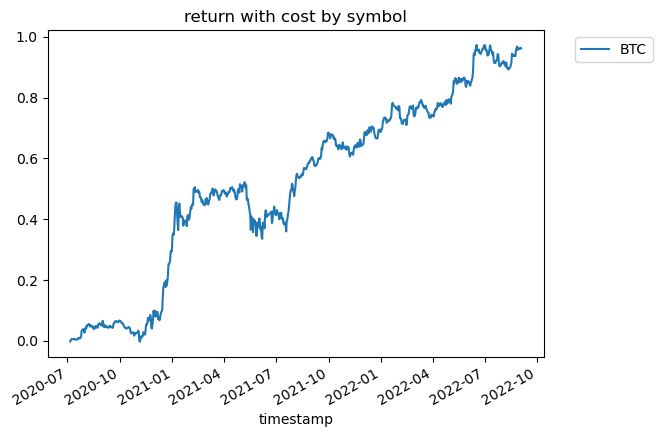

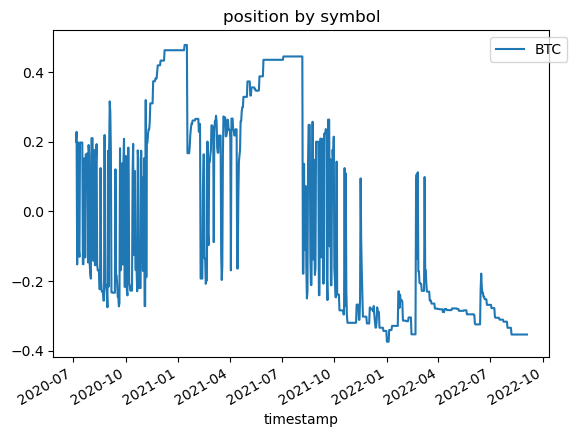

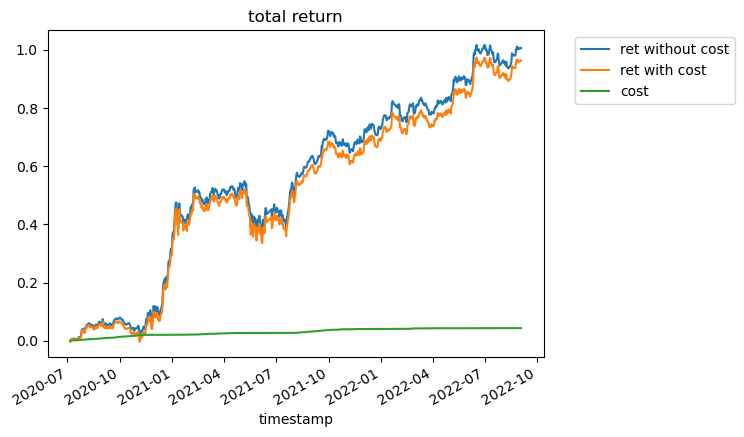

In [94]:
df = pd.read_pickle('/tmp/df_btc_price_type_none_daily.pkl')
df = df.reset_index().set_index('timestamp')
df_bchain = pd.read_pickle('/tmp/df_bchain.pkl')
df = df.join(df_bchain)
df = df.reset_index()
df['symbol'] = 'BTC'
df = df.set_index(['timestamp', 'symbol'])
df = df.dropna()
display(df)

model = ExampleModelBtc()

# cv
calc_position_cv(model, df, causal=True)
visualize_result(df.dropna())

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20220904_nn.xz', 'wb') as f:
    f.write(data)

83/83 [==============================] - 0s 1ms/step
timestamp                  symbol
2022-08-24 09:00:00+00:00  ADA       0.00
                           ATOM      0.00
                           BNB       0.00
                           BTC       0.00
                           DOT       0.00
                                     ... 
2022-09-04 09:00:00+00:00  ETH      -0.06
                           LINK      0.18
                           MATIC     0.02
                           SOL      -0.02
                           XRP       0.06
Name: position, Length: 2650, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict
83/83 [==============================] - 0s 2ms/step


position1  position2  position3
timestamp                 symbol                                 
2022-08-24 10:00:00+00:00 ADA     -0.055556  -0.055556       0.00
                          ATOM    -0.055556  -0.055556       0.00
                          BNB     -0.055556  -0.055556       0.00
                          BTC     -0.055556  -0.055556       0.00
                          DOT      0.500000   0.500000       0.00
...                                     ...        ...        ...
2022-09-04 08:00:00+00:00 ETH     -0.100000  -0.100000      -0.10
                          LINK     0.140000   0.140000       0.14
                          MATIC    0.100000   0.100000       0.10
                          SOL     -0.020000  -0.020000      -0.02
                          XRP      0.020000   0.020000       0.02

[2630 rows x 3 columns]

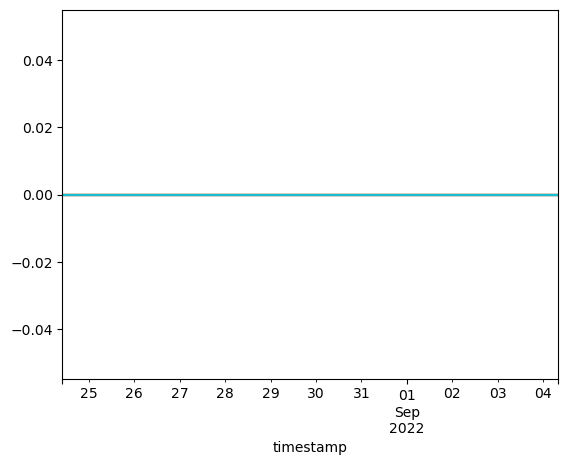

ADA (263, 4)
ATOM (263, 4)
BNB (263, 4)
BTC (263, 4)
DOT (263, 4)
ETH (263, 4)
LINK (263, 4)
MATIC (263, 4)
SOL (263, 4)
XRP (263, 4)


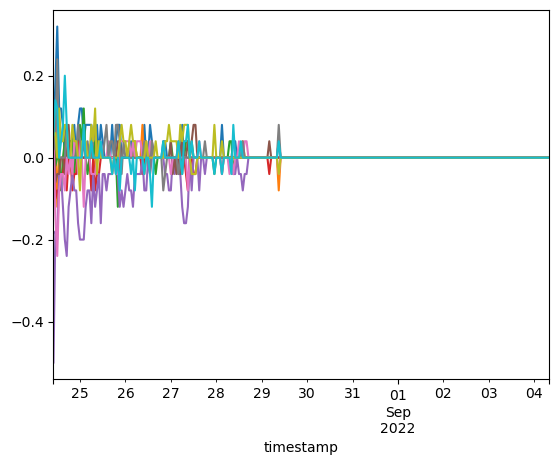

ADA (265, 3)
ATOM (265, 3)
BNB (265, 3)
BTC (265, 3)
DOT (265, 3)
ETH (265, 3)
LINK (265, 3)
MATIC (265, 3)
SOL (265, 3)
XRP (265, 3)


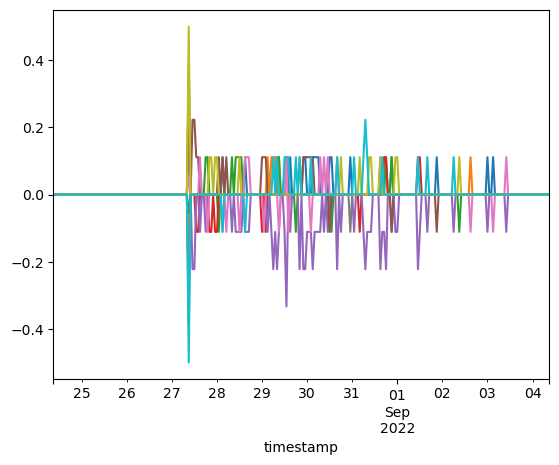

In [19]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20220904_nn.xz')
df = pd.read_pickle('/tmp/df_horizon96.pkl')
df = df[['op', 'hi', 'lo', 'cl']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

def _calc_features(df):        
    df = df.copy()

    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_momentum_{}'.format(i)] = (df['cl'] / df.groupby('symbol')['cl'].shift(i) - 1).fillna(0)
    for i in [2, 4, 8, 24, 48, 72]:
        df['feature_rsi_{}'.format(i)] = df.groupby('symbol')['cl'].transform(lambda x: talib.RSI(x, timeperiod=i).fillna(50))

    for col in get_feature_columns(df):
        df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5

    return df

df_features1 = _calc_features(df)
df_features3 = _calc_features(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

df_test2 = pd.concat([
    df_features1['feature_rsi_72'].rename('feature1'),
    df_features3['feature_rsi_72'].rename('feature3'),
    # df_features1['feature_momentum_72'].rename('feature1'),
    # df_features3['feature_momentum_72'].rename('feature3'),
], axis=1)

for symbol, df_symbol in df_test2.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['feature3'] - df_symbol['feature1']).plot()
plt.show()